# Tequila Basic Usage

## Create and Simulate Quantum Circuits

Tequila operators on abstract data types which can be translated and executed on various backends.  
In this part of the tutorial we show how to initialize and execute those.

First import tequila and check which backends are installed on your system.  
If supported backends are not installed you can for most of them just install them with
`pip install --upgrade name`  in your command line  
If you have old versions of supported backends installed that might get you in trouble.   
You can upgrade them with the same command.

In [1]:
import tequila as tq
tq.show_available_simulators()
from numpy import pi

backend         | wfn        | sampling   | noise      | installed 
--------------------------------------------------------------------
qulacs          | True       | True       | True       | True      
qiskit          | True       | True       | True       | True      
cirq            | True       | True       | True       | True      
pyquil          | True       | True       | True       | True      
symbolic        | True       | False      | False      | True      


### Create Simple Circuits

Lets create some simple unparametrized circutis.  
With unparametrized we mean here, that possible angles in the circuits are fixed.  
You can create tequila circuits and gates over the `tq.gates` module.  
Gates and circuits can be glued together with the `+` operation.  

Gates can receive the keyword arguments `target` and `control` which defines qubit(s) on which the gates act

In [2]:
circuit = tq.gates.H(target=0) + tq.gates.CNOT(target=1,control=0)

Circuits can be printed out in list-type form or can be drawn by the backends.  
The result of tq.draw will depend which backends you have installed.  
If you want to draw with a specific backend, just pass the `backend` keyword, e.g. tq.draw(circuit,`backend='cirq'`)

In [3]:
print(circuit)

circuit: 
H(target=(0,))
X(target=(1,), control=(0,))



In [4]:
tq.draw(circuit)

0: ───H───@───
          │
1: ───────X───


Lets do the same with a list of qubits and see what happens

In [5]:
circuit = tq.gates.H(target=[0,1]) + tq.gates.X(target=1, control=0)
tq.draw(circuit)

0: ───H───@───
          │
1: ───H───X───


Some gates have to be parametrized by `angle` and some can be parametrized by `power`.  
Note that if you use cirq to draw circuits, it will display those in different units. This does not affect the simulation.

Tequila uses the standard convention for qubit rotations:
$$
R_i(\theta) = e^{-i\frac{\theta}{2} \sigma_i}, \qquad i \in \left\{ X, Y, Z \right\}
$$

which is carried over for multi-qubit rotations
$$
R_P(\theta) = e^{-i\frac{\theta}{2} P}
$$
where $P$ is a paulistring like e.g. $X(0)Y(1)$

In [6]:
# Some further examples
circuit0 = tq.gates.Ry(angle=1.0, target=0) + tq.gates.X(target=1, control=0)
circuit1 = tq.gates.Y(power=0.5, target=0) + tq.gates.Ry(angle=1.0, target=1, control=0)
circuit2 = tq.gates.Rp(angle=1.0, paulistring="Y(0)") + tq.gates.X(target=1, control=0) # acts the same as circuit0
circuit3 = tq.gates.Rp(angle=1.0, paulistring="X(0)Y(1)")

generator = tq.paulis.Y(0)
circuit4 = tq.gates.Trotterized(generators=[generator], angles=[1.0], steps=1) # acts the same as circuit0
generator = tq.paulis.X(0)*tq.paulis.Y(1)
circuit5 = tq.gates.Trotterized(generators=[generator], angles=[1.0], steps=1) # acts the same as circuit3

tq.draw(circuit3)

0: ───H──────────@────────────────@───H───────────
                 │                │
1: ───Rx(0.5π)───X───Rz(0.318π)───X───Rx(-0.5π)───


### Simulate and Sample Simple Circuits

Lets simulate our last created circuit.  
This can be done by the `tq.simulate` function.   
The return type is a `QubitWaveFunction`

In [7]:
wfn = tq.simulate(circuit)
print(wfn)

+0.5000|00> +0.5000|10> +0.5000|01> +0.5000|11> 


You can control on which backend the simulation is executed with the `backend=name` keyword where name is one of the backends that are installed on your system (see first cell)  

In [8]:
# simulate on 'qulacs' backend (which is the default)
# Note that this cell will crash if qulacs is not installed
# just switch the name with something that is installed on your system (check the first cell)
wfn = tq.simulate(circuit, backend='qulacs')
print(wfn)

+0.5000|00> +0.5000|10> +0.5000|01> +0.5000|11> 


If you don't want to simulate a full wavefunction but rather simulate individual samples from it you can pass down the `samples=integer` keyword

In [9]:
measurements = tq.simulate(circuit, samples=10)
print(measurements)

+10.0000|00> 


You can access the individual measurements either by integers in binary notation or by binary strings

In [10]:
print(measurements(0))
print(measurements("00"))
print(measurements(2))
print(measurements("10"))

10
10
0.0
0.0


Individual Measurement instructions can be added to the circuit via `tq.gates.Measurement`

In [11]:
measurements = tq.simulate(circuit+tq.gates.Measurement(target=[0]), samples=10)
print(measurements)

+2.0000|10> +8.0000|00> 


### Create Parametrized Circuits

Now we will explore how to create parametrized circuits.  
This works analogue to the simple circuits before, just that `angle` and `power` can be set to hashable types.  
You can either initialize the variable directly or you can create a tequila variable object and use that.  
The latter is only important if you intend to pass down a manipulated variable (like for example $a^2$ instead of just $a$)

Lets start with something simple: A parametrized rotation on a single qubit.  
We will call the variable $a$.  
If the circuit gets simulated the value of the variable has to be specified.  
This is done by passing down a dictionary holding the names and values of all variables.

In [12]:
# initialize the parametrized circuit
circuit = tq.gates.Ry(angle="a", target=0)
pi = tq.numpy.pi
# set the value we want to simulate
variables = {"a" : pi**2}
wfn = tq.simulate(circuit, variables=variables)
print(wfn)

+0.2206|0> -0.9754|1> 


You can see if a circuit is parametrized by calling `extract_variables` from the circuit.  
Note that if you use the cirq backend to draw the circuit

In [13]:
print("circuit has variables: ", circuit.extract_variables())

circuit has variables:  [a]


Now the same thing a little more sophisticated.  
We will parametrized the gate by $a^2$ and also we want the $a$ to be in units of $\pi$ 

In [14]:
a = tq.Variable("a")

circuit = tq.gates.Ry(angle=(a*pi)**2, target=0)

# set the value we want to simulate
variables = {"a" : 1.0}
wfn = tq.simulate(circuit, variables=variables)
print(wfn)

+0.2206|0> -0.9754|1> 


Now the same again with a stronger transformation on the variables:  
In general, if you want to apply transformations on Variables (and later on Objectives) this can be done with   
`variable.apply(your_function)`.  
Here we will take the exponential function of numpy. Note that it is adviced to take those functions from `tq.numpy` since this will be the `jax` numpy used for automaticl differentiation.  
By doing so consistently you will avoid potential problems with gradients later.

In [15]:
a = tq.Variable("a")

circuit = tq.gates.Ry(angle=((a*pi)**2).apply(tq.numpy.exp), target=0)

# set the value we want to simulate
variables = {"a" : 1.0}
wfn = tq.simulate(circuit, variables=variables)
print(wfn)

-0.9856|0> -0.1692|1> 


Lets do the same thing once more, but this time with a customized transformation (which will do the same as in the last cell)

In [16]:
# define your own transformation
def my_trafo(x):
    return tq.numpy.exp(x**2)

a = tq.Variable("a")

# we will put the variable manipulation here for more overview
a = a*pi # a is now in a*pi
a = a.apply(my_trafo) # a is now exp((a*pi)**2)

circuit = tq.gates.Ry(angle=a, target=0)

# set the value we want to simulate
variables = {"a" : 1.0}
wfn = tq.simulate(circuit, variables=variables)
print(wfn)

-0.9856|0> -0.1692|1> 


Note that you don't have to use strings as variable names.  
You can use any hashable type except numeric types since those will be interpeted as fixed numbers.
Here is one example using a combination of strings and tuples

In [17]:
circuit = tq.gates.Ry(angle=(1,"a", "its a stupid example"), target=0)
print(circuit.extract_variables())
circuit = tq.gates.Ry(angle=(1,2,3), target=0)
print(circuit.extract_variables())

[(1, 'a', 'its a stupid example')]
[(1, 2, 3)]


## Create and Simulate Objectives/Expectationvalues

Within tequila you can define qubit operators which can either be used to generate gates and circuits over `tq.gates.Rp`, `tq.gates.Trotterized` or `tq.gates.GeneralizedRotation` or as Hamiltonians defining the measurements on the quantum experiments. 

`QCircuit` and `QubitHamiltonian` objects can be combined to expectation values which can be combined and transformed to become more general `Objectives` (in tequila an expectation value is already objective in its simplest form).

We will start by demonstrating this with a simple one qubit example.  
We will take the one qubit rotation gate from previous sections and use a simple pauli operator as hamiltonian.
So our expectation value will be:  

$$
E = \langle\Psi(a)\rvert H \lvert\Psi(a) \rangle = \langle0\rvert U^\dagger\left(a\right) H  U\left(a\right) \lvert 0\rangle = \langle H \rangle_{ U\left(a\right)}
$$  
  
where $H = \sigma_x = X $ and $ U\left(a\right) = Ry(a)$

In [18]:
# the circuit
U = tq.gates.Ry(angle="a", target=0)
# the Hamiltonian
H = tq.paulis.X(0)
# the Objective (a single expectation value)
E = tq.ExpectationValue(H=H, U=U)
print("Hamiltonian ", H)
print(E)

Hamiltonian  +1.0000X(0)
Objective with 1 unique expectation values
variables = [a]
types     = not compiled


In [19]:
# better not use it for large objectives
tq.draw(E)

Objective with 1 unique expectation values
variables = [a]
types     = not compiled

Expectation Value 0
Hamiltonian :  (+1.0000X(0),)
variables :  [a]
circuit:

0: ───Ry(0.318309886183791*pi*f((a,))_0)───


Lets simulate the objective for some choices of our variable.  
Note that the simulate function is the same as before for the circuits, you can use the `backend` and `sample` key in the same way.  

Since the objective is defined with parametrized quantum circuits, the values of the variables have to be passed down in the same way as before.  

Note that not all expectationvalues in the objective need to be parametrized and that the parameters don't need to be the same.  

In [20]:
variables = {"a": 1.0}
value = tq.simulate(E, variables=variables)
print("Objective({}) = {}".format(variables["a"], value))

Objective(1.0) = 0.8414709848078965


Here are some more intuitive examples of Hamiltonians.  
Note that those operators are not automatically hermitian.  
You can use the `split` function to get the hermitian and/or antihermitian part  
Check also the `FAQ` notebook for some more information.

In [21]:
# Pauli Operators can be initialilzed and added/multipled 
H = tq.paulis.X(qubit=[0,1,2,3]) + tq.paulis.Y(2) + tq.paulis.Z(qubit=[0,1])*tq.paulis.X(2)
print(H, " is hermitian = ", H.is_hermitian())

H = tq.paulis.Z(0)*tq.paulis.Y(0) + tq.paulis.X(0)
print(H, " is hermitian = ", H.is_hermitian())

hermitian_part, anti_hermitian_part = H.split()
print("hermitian part      = ", hermitian_part)
print("anti-hermitian part = ", anti_hermitian_part)

H = tq.paulis.Projector("|00>")
print(H, " is hermitian = ", H.is_hermitian())

H = tq.paulis.Projector("1.0*|00> + 1.0*|11>")
print(H, " is hermitian = ", H.is_hermitian())


+1.0000X(0)X(1)X(2)X(3)+1.0000Y(2)+1.0000Z(0)Z(1)X(2)  is hermitian =  True
+1.4142e^(-0.2500πi)X(0)  is hermitian =  False
hermitian part      =  +1.0000X(0)
anti-hermitian part =  -1.0000iX(0)
+0.2500+0.2500Z(1)+0.2500Z(0)+0.2500Z(0)Z(1)  is hermitian =  True
+0.5000+0.5000Z(0)Z(1)+0.5000X(0)X(1)-0.5000Y(0)Y(1)  is hermitian =  True


Lets proceed with our previous simple example of a single qubit rotation and a single X as Hamiltonian.

If you intent to evaluate the objective with lots of different choices of the variables it is useful to compile it.  A compiled objective is tied to a specific backend and can be used like a function taking a dictionary of variables.

The compile function takes also the `backend` and `sample` keyword. If no backend is chosen tequila will pick automatically from the installed ones. If you intent to sample your objective instead of fully simulate it you can give a dummy integer of samples to `compile`. This will help tequila pick the best available backend but will not fix the number of samples for future evaluations.

Compiling first will make your code faster since then the abstract circuits do not need to be re-translated to the backend every time.

In [22]:
compiled_objective = tq.compile(E)

# the compiled objective can now be used like a function
for value in [0.0, 0.5, 1.0]:
    evaluated = compiled_objective(variables={"a": value})
    print("objective({}) = {}".format(value, evaluated))

objective(0.0) = 0.0
objective(0.5) = 0.479425538604203
objective(1.0) = 0.8414709848078965


Lets simulate our compiled objetive and plot the results

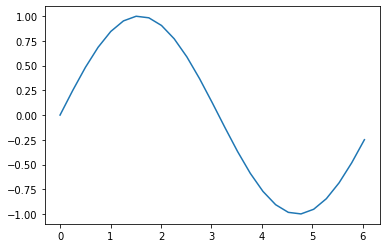

In [23]:
def compile_and_evaluate(objective, steps=25, samples=None, start=0, stop=2*pi):
    from matplotlib import pyplot as plt
    plt.figure()
    
    compiled_objective = tq.compile(objective, samples=samples)
    values = [start + (stop-start)*step/steps for step in range(steps)]
    evaluated = [compiled_objective(variables={"a": value}, samples=samples) for value in values]

    plt.plot(values, evaluated)
    plt.show()
    return values, evaluated

compile_and_evaluate(E);

Lets do the same again with a more complicated objective.  
Lets take the square of our original expectation value and shift it by 1

$$
L = E^2 + 1
$$

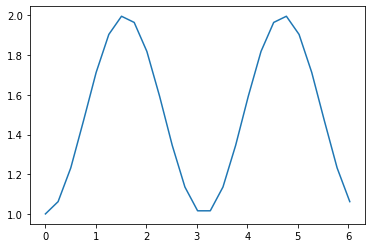

In [24]:
# this is the new objective
L = E**2 + 1

compile_and_evaluate(L);

And the same, but shifted by $e^{-a^2}$, so the shift is not constant and will only affect $L$ for small values of $a$.

$$
L = E^2 + e^{-a^2}
$$

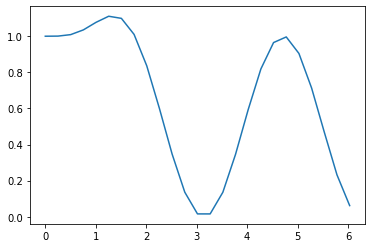

In [25]:
# For completeness we initialize the variable again here
a = tq.Variable("a")
# to be sure that the variable is the same as the one from the objective we could also do
# a = objective.extract_variables()[0]

# this is the new objective
L = E**2 + (-a**2).apply(tq.numpy.exp)

compile_and_evaluate(L);

Now we also transform the expectation value in a more complicated way. It works the same way as it works for variables

$$
L = exp(-E^2) + exp(-a^2)E
$$

Note that the original expectation value now enters two times into the objective.  
But tequila will only evaluate it once per run.

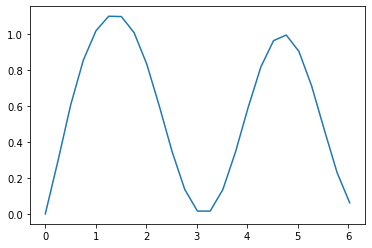

Objective with 1 unique expectation values
variables = [a]
types     = not compiled


In [26]:
# For completeness we initialize the variable again here
a = tq.Variable("a")
# to be sure that the variable is the same as the one from the objective we could also do
# a = objective.extract_variables()[0]

# this is the new objective
L = E**2 + (-a**2).apply(tq.numpy.exp)*E

compile_and_evaluate(L);

# check how many (unique) expectation values are in the objective
print(L)

At last, lets take our last objective but sample from it. 
This means that in the evaluation of the expectation value the measurements on the underlying circuit are sampled.  
Feel free to play with the number of samples.

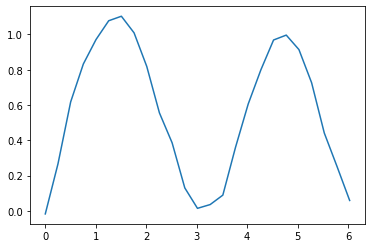

Objective with 1 unique expectation values
variables = [a]
types     = not compiled


In [27]:
# For completeness we initialize the variable again here
a = tq.Variable("a")
# to be sure that the variable is the same as the one from the objective we could also do
# a = objective.extract_variables()[0]

# this is the new objective
L = E**2 + (-a**2).apply(tq.numpy.exp)*E

compile_and_evaluate(L, samples=1000);

# check how many (unique) expectation values are in the objective
print(L)

### Derivatived of Objectives

Derivatives of objectives are objectives themselves.
They can be simply created by applying `tq.grad` on a objective.  

Lets take first objective and plot its derivative.
The first is easy to check since the derivative should just be the shifted sinus curve.
Feel free to change the objective and play around.


Objective:
 Objective with 1 unique expectation values
variables = [a]
types     = not compiled


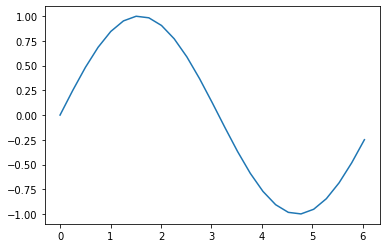

First Derivative:
 Objective with 2 unique expectation values
variables = [a]
types     = not compiled


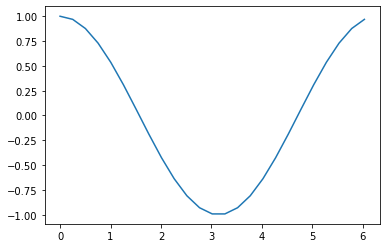

Second Derivative:
 Objective with 6 unique expectation values
variables = [a]
types     = not compiled


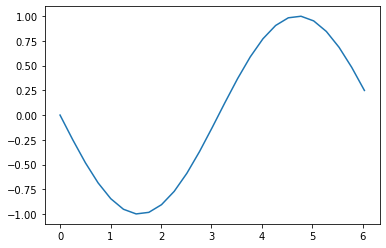

In [28]:
L = E

dLda = tq.grad(L, "a")
d2Ld2a = tq.grad(dLda, "a")
print("Objective:\n", L)
compile_and_evaluate(L);
print("First Derivative:\n",dLda)
compile_and_evaluate(dLda);
print("Second Derivative:\n",d2Ld2a)
compile_and_evaluate(d2Ld2a);


Objective:
 Objective with 1 unique expectation values
variables = [a]
types     = not compiled


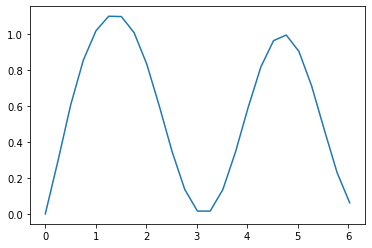

First Derivative:
 Objective with 3 unique expectation values
variables = [a]
types     = not compiled


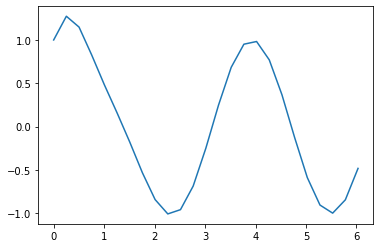

Second Derivative:
 Objective with 9 unique expectation values
variables = [a]
types     = not compiled


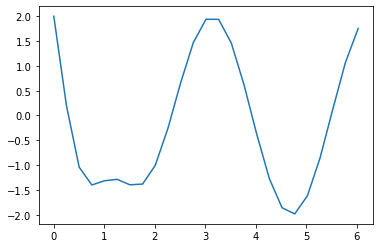

In [29]:
# another example
L = E**2 + (-a**2).apply(tq.numpy.exp)*E
dLda = tq.grad(L, "a")
d2Ld2a = tq.grad(dLda, "a")
print("Objective:\n", L)
compile_and_evaluate(L);
print("First Derivative:\n",dLda)
compile_and_evaluate(dLda);
print("Second Derivative:\n",d2Ld2a)
compile_and_evaluate(d2Ld2a);




# All in one

At last we will create a small toy objective and use the phoenics optimizer to find local minima.  

As expectation value we will use an entangled circuit with one CNOT gate and one Ry rotation and an arbitrary chosen Hamiltonian.

Our objective is defined as

$$\displaystyle
L = \langle H \rangle_{U(a)} + e^{-\left(\frac{\partial}{\partial a} \langle H \rangle_{U_{a}}\right)^2 }
$$

with 

$$
H = -X(0)X(1) + \frac{1}{2}Z(0) + Y(1)
$$

and 

$$
U = e^{-\frac{e^{-a^2}}{2} Y(0)} \text{CNOT}(0,1)
$$

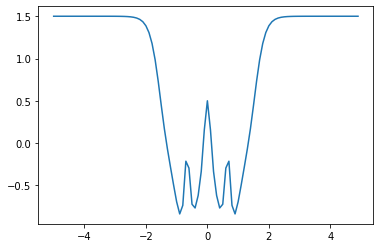

In [30]:
# All in one

a = tq.Variable("a")
U = tq.gates.Ry(angle=(-a**2).apply(tq.numpy.exp)*pi, target=0)
U += tq.gates.X(target=1, control=0)

H = tq.QubitHamiltonian.from_string("-1.0*X(0)X(1)+0.5Z(0)+Y(1)")

E = tq.ExpectationValue(H=H, U=U)
dE = tq.grad(E, "a")

objective = E + (-dE**2).apply(tq.numpy.exp)

param, values = compile_and_evaluate(objective, steps=100, start =-5, stop=5);

In [31]:
# We need to specify the phoenics config here
# the only change is that we are changing the interval for periodic boundary conditions to [-3,3] istead df [0, 2pi]
# not that the original interval would also work here
# we are restricting the search to 10 iterations here
# check out the notebook on phoenics for more information
phoenics_config = {'general': {'auto_desc_gen': 'False', 'batches': 5, 'boosted': 'False', 'parallel': 'False'}, 'parameters': [{'name': a, 'periodic': 'True', 'type': 'continuous', 'size': 1, 'low': -3., 'high': 3.}], 'objectives': [{'name': 'Energy', 'goal': 'minimize'}]}
result = tq.minimize(method='phoenics', objective = objective, phoenics_config = phoenics_config, maxiter=10)

phoenics has recieved
objective: 

Objective with 3 unique expectation values
variables = [a]
types     = not compiled
noise model : None
samples     : None
maxiter     : 10
variables   : [a]
passive var : {}
backend options qulacs  {}
now lets begin
[TIME]:   0:00:00.000471   (overall)
***********************************************
energy = +1.49948883 , angles= {a: 2.9565465450286865}
energy = -0.31946439 , angles= {a: -0.7203978896141052}
energy = +1.42141092 , angles= {a: 2.0654146671295166}
energy = +0.15096420 , angles= {a: -0.10101854801177979}
energy = -0.34576708 , angles= {a: -1.1709864139556885}
energy = +1.34663105 , angles= {a: 1.9432361125946045}
energy = -0.77466846 , angles= {a: -0.4097276031970978}
energy = +1.44883037 , angles= {a: 2.1426076889038086}
energy = +0.95215726 , angles= {a: -1.6853265762329102}
energy = -0.74158847 , angles= {a: -0.8014532327651978}
Quantum Objective evaluations: 0.17694354057312012s Wall-Time
[INFO] Acquisition ... starting process for 0

[TIME]:   67.84975814819336   (optimizing proposals)
[TIME]:   0:01:17.335417   (overall)
***********************************************
energy = -0.11987907 , angles= {a: -0.6646807789802551}
energy = -0.13946956 , angles= {a: -0.6401156187057495}
energy = -0.12103486 , angles= {a: -0.6661971807479858}
energy = -0.13555449 , angles= {a: -0.6419781446456909}
energy = -0.11854845 , angles= {a: -0.6620818376541138}
energy = -0.45360070 , angles= {a: -0.5699966549873352}
energy = -0.12204945 , angles= {a: -0.6672985553741455}
energy = -0.13081717 , angles= {a: -0.6445222496986389}
energy = -0.11824065 , angles= {a: -0.661016583442688}
energy = -0.16607094 , angles= {a: -0.687553346157074}
Quantum Objective evaluations: 0.09319853782653809s Wall-Time
best energy after 10 iterations : -0.84563261


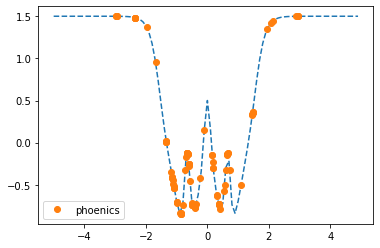

In [32]:
# plot the points phoenics visited
# the information is in the optimizer history
# we have 'angles' and `energies' giving us information about every evaluation
import matplotlib.pyplot as plt
points = {}
energies = result.history.energies
angles = result.history.angles
for it, energy in enumerate(energies):
    angle = angles[it][tq.Variable("a")]
    points[angle] = energy

plt.plot(param, values, linestyle="--")
plt.plot(list(points.keys()), list(points.values()), marker = "o", linestyle=" ", label="phoenics")
plt.legend()
plt.show()
    


In case you want to play with different optimizers (see also the SciPyOptimizers and FAQ notebooks)

In [2]:
tq.show_available_optimizers()

available methods for optimizer modules found on your system:
method               | optimizer module
--------------------------
NELDER-MEAD          | scipy
COBYLA               | scipy
POWELL               | scipy
SLSQP                | scipy
L-BFGS-B             | scipy
BFGS                 | scipy
CG                   | scipy
TNC                  | scipy
TRUST-KRYLOV         | scipy
NEWTON-CG            | scipy
DOGLEG               | scipy
TRUST-NCG            | scipy
TRUST-EXACT          | scipy
TRUST-CONSTR         | scipy
adam                 | gd
adagrad              | gd
adamax               | gd
nadam                | gd
sgd                  | gd
momentum             | gd
nesterov             | gd
rmsprop              | gd
rmsprop-nesterov     | gd
lbfgs                | gpyopt
direct               | gpyopt
cma                  | gpyopt
phoenics             | phoenics
Supported optimizer modules:  ['scipy', 'phoenics', 'gpyopt', 'gd']
Installed optimizer modules:  ['scipy', '